# **Phishing results**

NOT! Real results.
Dataset has to be generated (just 60 random samples are being used here). Just trying some graphs. Global variables to be changed.

In [36]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, precision_score, auc, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Changing paths to src
src_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(src_path)
from models.classifiers.DemocraticCoClassifier import DemocraticCo
from models.classifiers.TriTrainingClassifier import TriTraining
from models.classifiers.CoForestClassifier import CoForest

In [37]:
# Random Forest
random_forest_all = RandomForestClassifier(
    6, max_features='log2', random_state=5)

# Co Forest
co_forest = CoForest(6, 0.75, max_features='log2', random_state=5)

# Tri Training
tri_training = TriTraining(DecisionTreeClassifier(
), GaussianNB(), KNeighborsClassifier(), random_state=5)

# Democratic Co
democratic_co = DemocraticCo(
    [DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()], random_state=5)

cls = [random_forest_all, democratic_co, co_forest, tri_training]
cls_names = ["RF", "DC", "CoF", "TT"]


In [38]:
df = pd.read_csv(filepath_or_buffer="./fv/results-1/mix.csv")
X = df[df.columns[:-1]].values
y = df.tag.values.astype(int)

rd = np.random.RandomState(5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)


In [39]:
def get_comparation_graph(y_low_lim=0, curve='ROC'):

    fig, axes = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    colours = ['#82e0aa', '#3eccf6', '#de88f3', '#f39c12']
    scores = []
    recalls = []
    precisions = []
    AUCs = []

    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        L_train, U_train, Ly_train, Uy_train = train_test_split(
            X_train, y_train, test_size=0.8, random_state=rd, stratify=y_train)

        scores_experiment = []
        recalls_experiment = []
        precisions_experiment = []
        AUCs_experiment = []

        for cl, cl_name in zip(cls, cls_names):

            if cl_name == 'RF':
                cl.fit(X_train, y_train)
            else:
                cl.fit(L_train, Ly_train, U_train)
                
            y_pred = cl.predict(X_test)
            scores_experiment.append(accuracy_score(y_test, y_pred))
            recalls_experiment.append(recall_score(y_test, y_pred))
            precisions_experiment.append(precision_score(y_test, y_pred))

            if curve == 'ROC':
                fpr, tpr, _ = roc_curve(
                    y_test, cl.predict_proba(X_test)[:, 1])
                AUCs_experiment.append(auc(fpr, tpr))

            else:
                precision, recall, _ = precision_recall_curve(
                    y_test, cl.predict_proba(X_test)[:, 1])
                AUCs_experiment.append(auc(recall, precision))

        scores.append(scores_experiment)
        recalls.append(recalls_experiment)
        precisions.append(precisions_experiment)
        AUCs.append(AUCs_experiment)

    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(y_low_lim, 1.0)
    axes[0].bar(cls_names, np.mean(scores, axis=0), color=colours)

    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(y_low_lim, 1.0)
    axes[1].bar(cls_names, np.mean(recalls, axis=0), color=colours)

    axes[2].set_ylabel('Precision')
    axes[2].set_ylim(y_low_lim, 1.0)
    axes[2].bar(cls_names, np.mean(precisions, axis=0), color=colours)

    axes[3].set_ylabel('AUC')
    axes[3].set_ylim(y_low_lim, 1.0)
    axes[3].bar(cls_names, np.mean(AUCs, axis=0), color=colours)
    plt.plot()


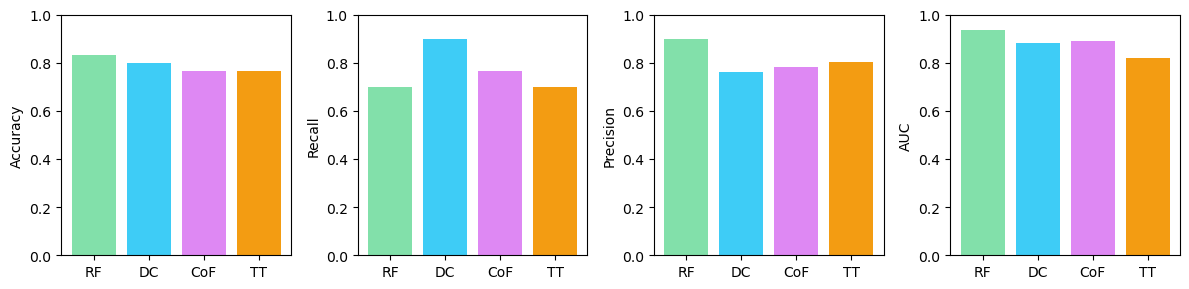

In [40]:
get_comparation_graph(0, curve='PR')
